# Cartesian Reduction Example

Here we show that a simple convolutional neural network (CNN) can learn to convert between a voxelized grid representation of atomic densities to Cartesian coordinats for a toy one-atom system.

In [1]:
import molgrid

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
n_types = 1
n_atoms = 1
radii = np.ones((n_types))*2.5  #fixed radius of 2.5A


We define a CNN with three layers of convolution/max pooling followed by fully connected layers to generate coordinates and types (which are irrelevant to this toy example).

In [4]:
class CNN(nn.Module):
    
    def __init__(self, gmaker, n_types, n_latent, type_radii, n_atoms=80):
        super(CNN, self).__init__()
        
        self.n_atoms = n_atoms
        self.type_radii = type_radii
        self.n_types = n_types
        
        dims = gmaker.grid_dimensions(n_types)
        
        self.conv1 = nn.Conv3d(n_types, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool3d(2)
        self.conv3 = nn.Conv3d(32, 32, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool3d(2)        
        self.last_layer_size = 32 * dims[1]//8 * dims[2]//8 * dims[3]//8
        self.fc_latent1 = nn.Linear(self.last_layer_size, n_latent)
        self.fc_coords = nn.Linear(n_latent, n_atoms*3)
        self.fc_types = nn.Linear(n_latent, n_atoms*(n_types))
        self.c2grid = molgrid.Coords2Grid(gmaker, center=(0,0,0))

    
    def to(self, device):
        ret = super(CNN, self).to(device)
        self.device = device
        return ret
    
    def forward(self, input, temp=0.0):
        
        batch_size = input.shape[0]
        
        # get latent encoding of true density from CNN
        x = F.elu(self.conv1(input))
        x = self.pool1(x)
        x = F.elu(self.conv2(x))
        x = self.pool2(x)    
        x = F.elu(self.conv3(x))
        x = self.pool3(x)            
        x = x.reshape(-1, self.last_layer_size)
        x = F.elu(self.fc_latent1(x))
        coords = self.fc_coords(x).view(batch_size, self.n_atoms, 3)
        types = F.softmax(self.fc_types(x).view(batch_size, self.n_atoms, -1), dim=-1)
        grid_gen = self.c2grid(coords, types, self.type_radii)

        return coords, types, grid_gen
        

An out-of-box loss is necessary to penalize generated coordinates that do not fit within the grid.

In [5]:
def out_of_box_loss(c, max_val):
    '''hingey loss at box boundaries'''
    return (0.1*F.relu(abs(c)-max_val)).sum()

In [6]:
def weight_init(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)


In [7]:
gmaker = molgrid.GridMaker(resolution=0.5, dimension=23.5, radius_type_indexed=True)
dims = gmaker.grid_dimensions(1)

grid_true = torch.empty(batch_size, *dims, dtype=torch.float32, device='cuda')
type_count_true = torch.empty(batch_size, n_types, dtype=torch.float32, device='cuda')

origtypes = torch.ones(batch_size,n_atoms,1,device='cuda')

#size radii for batches
batch_radii = torch.tensor(np.tile(radii, (batch_size, 1)), dtype=torch.float32, device='cuda')

In [8]:
#create model
model = CNN(gmaker, type_radii=batch_radii, n_types=1, n_latent=100, n_atoms=n_atoms).to('cuda')
model.apply(weight_init)
optimizer = optim.Adam(model.parameters(), lr=.0005)

In [9]:
grid_true.shape

torch.Size([10, 1, 48, 48, 48])

We compute starting losses (from random initialization) to get a sense of the magnitude of the loss of a random prediction.

In [10]:
# compute starting losses for normalization purposes    
origcoords = torch.rand(batch_size,n_atoms,3,device='cuda')*10-5
with torch.no_grad():

    for i in range(batch_size):
        gmaker.forward((0,0,0), origcoords[i], origtypes[i], batch_radii[i], grid_true[i])
    coords, types, grid_gen = model(grid_true)

    start_grid_loss = F.mse_loss(grid_true, grid_gen)
    oob_loss  = out_of_box_loss(coords, max_val=11.5)
    start_type_loss = F.mse_loss(type_count_true, types.sum(dim=1))

In [11]:
start_type_loss

tensor(1., device='cuda:0')

In [12]:
start_grid_loss

tensor(0.0015, device='cuda:0')

In [13]:
#setup plotting
def get_ylim(vals):
    min_val = 0 #min(vals)
    max_val = max(vals)
    val_range = max_val - min_val
    return min_val - 0.1*val_range, max_val + 0.1*val_range

import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
sns.set_palette('bright')
from IPython import display

grid_losses = []
oob_losses = []


We train by randomly generating coordinates of atoms, where each x,y,z coordinate ranges from -8 to 8.

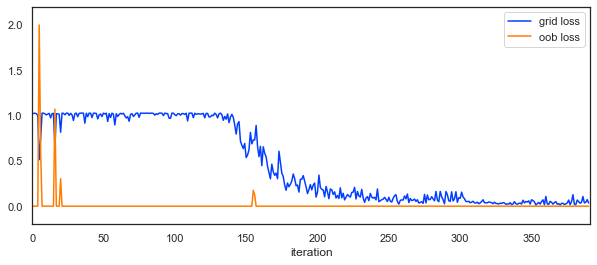

In [14]:
fig = plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(grid_losses, label='grid loss')
ax.plot(oob_losses, label='oob loss')

ax.legend(loc=1)
ax.set_xlabel('iteration')

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)


for iter in range(400):
    try:
        optimizer.zero_grad()
        #sample coordinates from -8 to 8
        origcoords = torch.rand(batch_size,n_atoms,3,device='cuda')*16-8

        for i in range(batch_size):
            gmaker.forward((0,0,0), origcoords[i], origtypes[i], batch_radii[i], grid_true[i])
        coords, types, grid_gen = model(grid_true)

        grid_loss = F.mse_loss(grid_true, grid_gen)
        oob_loss  = out_of_box_loss(coords, max_val=11.5)
        grid_loss    /= start_grid_loss

        loss = grid_loss + oob_loss 
        loss.backward()

        grid_losses.append(min(float(grid_loss),100)) # for viz
        oob_losses.append(min(float(oob_loss),2)) #for viz

        optimizer.step()
        scheduler.step()

        if iter % 10 == 0:
            x = len(grid_losses)
            ax.get_lines()[0].set_data(range(x), grid_losses)
            ax.get_lines()[1].set_data(range(x), oob_losses)
            ax.set_xlim(0, x)
            ax.set_ylim(get_ylim(grid_losses + oob_losses ))

            display.display(fig)
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        print('interrupted')
        break


In [15]:
with torch.no_grad(): #mean squared error on coordinates
    print(F.mse_loss(coords,origcoords))

tensor(0.0920, device='cuda:0')


In [16]:
true = origcoords.detach().cpu().numpy().reshape(10,3)
pred = coords.detach().cpu().numpy().reshape(10,3)

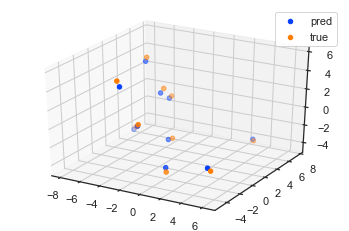

In [17]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pred[:,0],pred[:,1],pred[:,2],label='pred')
ax.scatter(true[:,0],true[:,1],true[:,2],label='true')
plt.legend();

Because the atomic gradient is "short sighted" - it can only "see" areas of the grid that overlap the atom, we can train faster by warming up the model with generated coordinates that span a smaller range initially (and are closer to the near-zero coordinates generated from random weights).

In [18]:
grid_losses = []
oob_losses = []

#recreate model
model = CNN(gmaker, type_radii=batch_radii, n_types=1, n_latent=100, n_atoms=n_atoms).to('cuda')
model.apply(weight_init)
optimizer = optim.Adam(model.parameters(), lr=.0005)

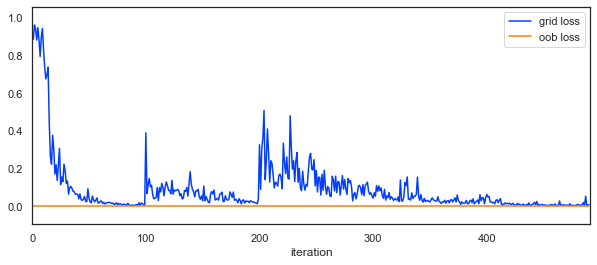

In [19]:
#size radii for batches
batch_radii = torch.tensor(np.tile(radii, (batch_size, 1)), dtype=torch.float32, device='cuda')

fig = plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(grid_losses, label='grid loss')
ax.plot(oob_losses, label='oob loss')

ax.legend(loc=1)
ax.set_xlabel('iteration')

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)

for maxcoord in [4,6,8,8,8]:
    for iter in range(100):
        try:
            optimizer.zero_grad()
            origcoords = torch.rand(batch_size,n_atoms,3,device='cuda')*2*maxcoord-maxcoord

            for i in range(batch_size):
                gmaker.forward((0,0,0), origcoords[i], origtypes[i], batch_radii[i], grid_true[i])
            coords, types, grid_gen = model(grid_true)

            grid_loss = F.mse_loss(grid_true, grid_gen)
            oob_loss  = out_of_box_loss(coords, max_val=11.5)
            grid_loss    /= start_grid_loss

            loss = grid_loss + oob_loss 
            loss.backward()

            grid_losses.append(min(float(grid_loss),100)) # for viz
            oob_losses.append(min(float(oob_loss),2)) #for viz

            optimizer.step()
            scheduler.step()


            if iter % 10 == 0:
                x = len(grid_losses)
                ax.get_lines()[0].set_data(range(x), grid_losses)
                ax.get_lines()[1].set_data(range(x), oob_losses)
                ax.set_xlim(0, x)
                ax.set_ylim(get_ylim(grid_losses + oob_losses ))

                display.display(fig)
                display.clear_output(wait=True)

        except KeyboardInterrupt:
            print('interrupted')
            break


In [20]:
with torch.no_grad(): #mean squared error on coordinates
    print(F.mse_loss(coords,origcoords))

tensor(0.0066, device='cuda:0')


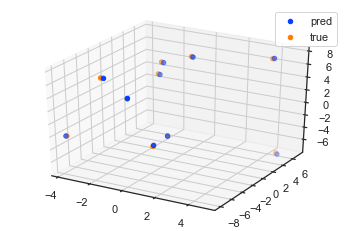

In [21]:
true = origcoords.detach().cpu().numpy().reshape(10,3)
pred = coords.detach().cpu().numpy().reshape(10,3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pred[:,0],pred[:,1],pred[:,2],label='pred')
ax.scatter(true[:,0],true[:,1],true[:,2],label='true')
plt.legend();

We achieve coordinate accuracy more than an order of magnitude better than the grid resolution (0.5A).